# Acquire & Refine the Data


## Items, Users, Signal

- **Items**: Objects to be recommended
- **Users**: Target of the recommendation
- **Signal**: Explicit or Implicit feedback between Items and users

In our context
- Items are **stories** posted on HN
- Users are **users** commenting or posting stories
- Signal are **comments** on the stories by the user signalling interest

## Source of Data 

Lets see the sources for getting historical information posted on HackerNews

- **HackerNews API** - YCombinator provides an official hackernew api through Firebase. This is a near real-time database and provides both an *items* (stories and comments) as well as an *users* api.  It is available at https://github.com/HackerNews/API

- **BigQuery** : Google Big Query has a daily updated HackerNews public dataset available (from 2006 to date). It only has *items* information. It is available at https://bigquery.cloud.google.com/table/bigquery-public-data:hacker_news.full

## Items (Stories) 

The schema for the Big Query table is

| Field       | Type      | Description                           |
|:------------|----------:|:--------------------------------------|
| by          | STRING    | The username of the item's author.    |
| score       | INTEGER   | Story score                           |
| time        | INTEGER   | Unix time                             |
| timestamp   | TIMESTAMP | Timestamp for the unix time           |
| title       | STRING    | Story title                           |
| type        | STRING    | Type of details (comment, story, ...) |
| url         | STRING    | Story url                             |
| text        | STRING    | Story or comment text                 |
| parent      | INTEGER   | Parent comment ID                     |
| deleted     | BOOLEAN   | Is deleted?                           |
| dead        | BOOLEAN   | Is dead?                              |
| descendants | INTEGER   | Number of story or poll descendants   |
| id          | INTEGER   | The item's unique id.                 |
| ranking     | INTEGER   | Comment ranking                       |


- Get all the stories posted on HackerNews in **2017 (till date)**. 
- To ensure a relevant set, we will limit the stories which have atleast have **score of 5 points or more** on them. 

We will can use the BigQuery Web Interface to do this. (We can also use the python api for doing it...)

```SQL
#standardSQL
SELECT * 
FROM `bigquery-public-data.hacker_news.full`
WHERE type="story" AND score > 4 AND EXTRACT(YEAR FROM timestamp)=2017
```

This dataset is available in `data\stories2017score5.gzip`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
%matplotlib inline

In [3]:
# Read the gzip file into memory
stories_all = pd.read_csv("data/stories2017score5.csv.gzip", compression='gzip', low_memory=False)

In [4]:
# Lets see the number of records
stories_all.shape

(56757, 14)

In [5]:
stories_all.head()

,by,score,time,timestamp,title,type,url,text,parent,deleted,dead,descendants,id,ranking
0,edsouza,5,1510895219,2017-11-17 05:06:59 UTC,Meet the Tesla Semitruck,story,https://www.wired.com/story/tesla-truck-revealed/,NaN,NaN,NaN,True,NaN,15719098,NaN
1,mathchick,5,1495226520,2017-05-19 20:42:00 UTC,Raising Rebel Girls,story,https://code.likeagirl.io/raising-rebel-girls-...,NaN,NaN,NaN,True,NaN,14379186,NaN
2,jscholes,5,1498940583,2017-07-01 20:23:03 UTC,Woman accidentally kills her boyfriend in atte...,story,https://arstechnica.com/tech-policy/2017/06/in...,NaN,NaN,NaN,True,NaN,14678802,NaN
3,huangc10,5,1510186454,2017-11-09 00:14:14 UTC,Coinbase is Down,story,https://www.coinbase.com/,NaN,NaN,NaN,True,NaN,15658508,NaN
4,calebgarling,5,1513012293,2017-12-11 17:11:33 UTC,Was Donald Trump a Robot?,story,https://shorterletter.com/was-donald-trump-a-r...,NaN,NaN,NaN,True,NaN,15898391,NaN


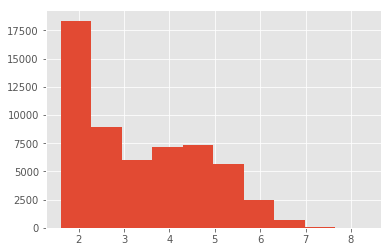

In [6]:
# Plotting the Score
np.log(stories_all.score).hist()

### Most Popular Stories

For this exercise:
- Let us choose the most popular stories with a score > 500 over the last year
- Lets keep the columns - user (by), userId (id), score (score), title (title)


In [18]:
# Get stories with score > 500
stories = stories_all[stories_all.score > 500].copy()

In [19]:
# Sort by score and select columns
stories.sort_values('score', ascending=False)
stories = stories[['id', 'title' , 'score', 'by']]

In [20]:
# Change column names
stories_column = ['story', 'title',  'score', 'user']
stories.columns = stories_column

In [21]:
stories.head()

,story,title,score,user
1908,14274033,"Uber is valued at $70B, you can get it at $999",503,appoets
15284,14107522,Jeff Bezos’ Annual Letter,547,djyaz1200
15291,13647190,India has banned disposable plastic in Delhi,671,SimplyUseless
15296,13309610,Startup Puts Everything You Need for a Two-Acr...,511,kungfudoi
15297,13860890,The Uber Bombshell About to Drop,1089,dantiberian


In [65]:
# Write to disk
stories.to_csv('data/stories.csv', index=False)

## Item (Story) - User - Signal (Comment)

Lets get all the comments from the database (using BigQuery) and keep only the user and story information

```SQL
#standardSQL
SELECT  parent, by
FROM `bigquery-public-data.hacker_news.full`
WHERE type="comment" AND parent IN 
 (SELECT id
  FROM `bigquery-public-data.hacker_news.full`
  WHERE type="story" AND score > 4 AND EXTRACT(YEAR FROM timestamp)=2017)
```  


In [22]:
# Lets load the compressed data
comments_all = pd.read_csv("data/bycomments2017score5.csv.gz", compression='gzip', low_memory=False)

In [23]:
# Lets see the size
comments_all.shape

(450884, 2)

In [24]:
comments_all.head()

,by,parent
0,NaN,15332819
1,NaN,15361981
2,NaN,13939068
3,NaN,15773920
4,NaN,15824599


In [25]:
# Remove the NAs and Change the column names
comments_all.dropna(inplace = True)
comments_all.columns = ['user', 'story']

In [26]:
# Lets add a comment fields as 1 (as one comment was made)
comments_all['comment'] = 1
comments_all.head()

,user,story,comment
13153,05,15878548,1
13154,0a,13850516,1
13155,1k,15783427,1
13156,1k,14602595,1
13157,21,14192353,1


Lets keep the `story - user` combination for only the stories we are interested to recommend

In [27]:
# Lets select comments for the our list of recommended stories
story_user_comment = comments_all[comments_all['story'].isin(stories.story)]

In [28]:
# Size of the list
story_user_comment.shape

(52460, 3)

In [66]:
story_user_comment.to_csv('data/story_user_comment.csv', index=False)

## Users 

We need to get the details for all the users that have made comments in our list of stories.

Also, we are interested in their details
- How long have they been on the HN platform? (Created)
- How active they are? (# of comments)?
- How good they are to the HN community (karma)?


In [29]:
# All the users that have commented on the top stories
users_list = story_user_comment.user.unique()

In [183]:
len(users_list)

23230

We will need to get the User Information from HN

- **Hacker News API**: Official API hosted on Firebase - https://github.com/HackerNews/API
- **Haxor**: Unofficial HN Python API c- https://github.com/avinassh/haxor
- **Ascynio-HN**: A very fast async Python API for HackerNews - https://github.com/itielshwartz/asyncio-hn

Lets use the HackerNews API

In [38]:
import requests

In [84]:
# Lets get the first user
user = users_list[0]

# Lets get karma, created date and number of comments
r = requests.get("https://hacker-news.firebaseio.com/v0/user/" + user + ".json")
created = r.json()['created']
karma = r.json()['karma']
submitted = len(r.json()['submitted'])
print([user, created, karma, comments_num])

['21', 1454365382, 2189, 583]


Lets create a function to get the same detail from a list of users

In [43]:
def getUserData(users): 
    '''
    Function to get user details from the HackerNews API
    And store in a dataframe
    '''
    column_names = ['user', 'created', 'karma', 'submitted']
    userDf = pd.DataFrame(columns = column_names)

    for index, user in enumerate(users):
        
        #Get User Details
        try: 
            r = requests.get("https://hacker-news.firebaseio.com/v0/user/"+ user +".json")
            userDetails = r.json()            
        
            # Get details
            created = userDetails['created']
            karma = userDetails['karma']
            submitted = len(userDetails['submitted'])

            #Store in the DataFrame
            userDf.loc[index] = [user, created, karma, submitted] 
            #print([user, created, karma, submitted] )
            
            #Print every hundred records to check progress
            if index%100 == 0:
                print(index)
            
        except:
            continue
     
    return userDf

In [102]:
def downloadUserAll(users_list): 
    total = len(users_list)
    turn = int(total/20)
    start = 0
    end = turn
    
    for i in range(1, 21):
        user_df_step = getUserData(users_list[start:end])
        user_df_step.to_csv("data/users" + str(i) + ".csv", index=False)
        print(start, end, "data/users" + str(i) + ".csv")
        start = end
        end = min(end + turn, total)
    

In [103]:
# Lets dowload all the user data 
# Note: This takes about an hour to run... so use the already downloaded files

# downloadUserAll(users_list)

In [104]:
# Lets create the users database
column_names = ['user', 'created', 'karma', 'submitted']
users = pd.DataFrame(columns = column_names)

for i in range(1,21):
    print(i)
    user_df_step = pd.read_csv("data/users" + str(i) + ".csv")
    users = pd.concat([users, user_df_step], ignore_index=True)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [118]:
# Lets confirm we have all the data
list(users.tail().user), users_list[-5:]

(['throwaway198411',
  'throwaway292939',
  'throwawaymaroon',
  'throwyfoundr134',
  'trumpownsyou420'],
 array(['throwaway198411', 'throwaway292939', 'throwawaymaroon',
        'throwyfoundr134', 'trumpownsyou420'], dtype=object))

In [119]:
# Lets save the users matrix
users.to_csv('data/users.csv', index=False)